In [2]:
import pickle
from random import randint
import string
import re
import math
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import spacy

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim import corpora, models, similarities, matutils

from wordcloud import WordCloud

# # libraries for visualization
# import pyLDAvis
# import pyLDAvis.gensim
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [3]:
# load doc into memory
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text

In [4]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [5]:
def seperate_verses(corpus):  
    split_corpus = corpus.split('\n\n')
    return split_corpus

In [6]:
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    
    # prepare regex for char filtering
    re_punc = re.compile('[%s]'% re.escape(string.punctuation))
    
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens 
              if word.isalpha()]
    
    # make lower case
    tokens = [word.lower() for word in tokens]
    
    return tokens

In [7]:
def clean_corpus(corpus):
    corpus = seperate_verses(corpus)
    cleaned_corpus = []
    for i in range(len(corpus)):
        cleaned_doc = clean_doc(corpus[i])
        cleaned_corpus.append(cleaned_doc)
        
    return cleaned_corpus

In [8]:
def corpus_docs_list_to_str(corpus):
    new_corpus = []
    for i in range(len(corpus)):
        new_doc = ' '.join(corpus[i])
        new_corpus.append(new_doc)
        
    return new_corpus

In [11]:
def corpus_to_tokens_to_sequences(corpus,sequence_length=50):
    tokens = ' '.join(corpus)
    tokens = tokens.split()
    # organize into sequences of tokens
    length = sequence_length + 1
    sequences = []
    for i in range(length, len(tokens)):
        # select sequence of tokens
        seq = tokens[i-length:i]
        # convert into a line
        line = ' '.join(seq)
        # store
        sequences.append(line)
    print('Total Sequences: %d' % len(sequences))
    return sequences

## Data Cleaning

In [12]:
bible = load_doc('kj_bible.txt')

In [13]:
# Seperating bible into old_testament
old_testament = bible[:3334014]
old_testament = old_testament[old_testament.find('1'):]

In [14]:
# Seperating bible into new_testament
new_testament = bible[3334014:]
new_testament = new_testament[new_testament.find('1'):]

In [15]:
# Clean entire old_testament
clean_old_testament = clean_corpus(old_testament)

# Clean entire new_testament
clean_new_testament = clean_corpus(new_testament)

In [16]:
# Converting verses from lists to strings
clean_old_testament = corpus_docs_list_to_str(clean_old_testament)
clean_new_testament = corpus_docs_list_to_str(clean_new_testament)

In [18]:
# Exporting clean_new_testament
out_filename = 'clean_new_testament.txt'
save_doc(clean_new_testament, out_filename)

# Exporting clean_old_testament
out_filename = 'clean_old_testament.txt'
save_doc(clean_old_testament, out_filename)

## NLP Preprocessing

In [34]:
def tokenize_corpus(corpus):
    tokenized_corpus = []
    for verse in corpus:
        tokenized_corpus.append(word_tokenize(verse))
    return tokenized_corpus        

In [343]:
old_test_extra_stopwords = ['shall','lord','unto','thou','thy','thee',
                            'god','son','said','king','israel','upon','ye',
                            'day','house','people','man','child','land','hath',
                            'hand','came','shalt','one','come','men','father',
                            'go','also','let']
new_test_extra_stopwords = ['unto','ye','shall','god','said','jesus','man',
                            'thou','thing','lord','one','also','come',
                            'christ','hath','came','u','day','thee','thy','saying','say'
                           'son','father','men','therefore','brother','let','went','saith']

In [344]:
def remove_stopwords(corpus,extra_stopwords):
    stop_words = stopwords.words('english')
    stop_words.extend(extra_stopwords)
    new_corpus = []
    for verse in corpus:
        new_verse = []
        for word in verse:
            if word not in stop_words:
                new_verse.append(word)
        new_corpus.append(new_verse)
    return new_corpus

In [42]:
def stemming_corpus(corpus):
    stemmed_corpus = []
    stemmer= PorterStemmer()
    for verse in corpus:
        stemmed_corpus.append([stemmer.stem(word) for word in verse])
    return stemmed_corpus

In [45]:
def lemmatize_corpus(corpus):
    lemmatized_corpus = []
    lemmatizer=WordNetLemmatizer()
    for verse in corpus:
        lemmatized_corpus.append([lemmatizer.lemmatize(word) for word in verse])
    return lemmatized_corpus

In [345]:
### Preprocessing Old Testament 

# Tokenizing 
tokenized_old_test = tokenize_corpus(clean_old_testament)

# Removing Stop Words 
tokenized_nostop_old_test = remove_stopwords(tokenized_old_test,old_test_extra_stopwords)

#Stemming and Lemmatizing
old_test_stemmed = stemming_corpus(tokenized_nostop_old_test)
old_test_lemmatized = lemmatize_corpus(tokenized_nostop_old_test)

In [346]:
### Preprocessing New Testament 

# Tokenizing 
tokenized_new_test = tokenize_corpus(clean_new_testament)

# Removing Stop Words 
tokenized_nostop_new_test = remove_stopwords(tokenized_new_test,new_test_extra_stopwords)

#Stemming and Lemmatizing
new_test_stemmed = stemming_corpus(tokenized_nostop_new_test)
new_test_lemmatized = lemmatize_corpus(tokenized_nostop_new_test)

In [347]:
avg_length = []
for verse in new_test_lemmatized:
    avg_length.append(len(verse))

np.array(avg_length).mean()

10.799289820764288

## Exploratory Data Analysis

In [227]:
def join_tokenized_words(corpus):
    
    all_words = []
    for verse in corpus:
        joined_verse = ' '.join(verse)
        all_words.append(joined_verse)
    
    return all_words

In [226]:
def join_tokenized_verses(corpus):
    
    all_words = join_tokenized_words(corpus)
    all_words = ' '.join(all_words)
    all_words = all_words.split()
    
    return all_words

In [314]:
# function to plot most frequent terms
def freq_words(corpus, terms=30):
    
    fdist = FreqDist(corpus)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    return list(d.word)

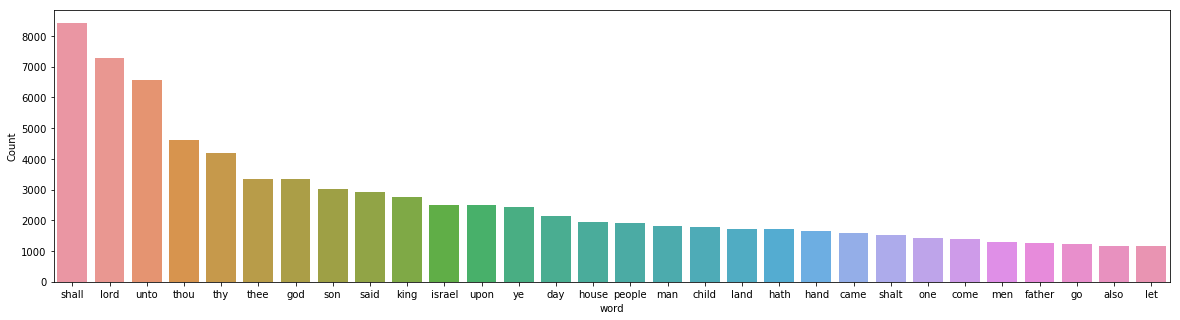

['shall',
 'lord',
 'unto',
 'thou',
 'thy',
 'thee',
 'god',
 'son',
 'said',
 'king',
 'israel',
 'upon',
 'ye',
 'day',
 'house',
 'people',
 'man',
 'child',
 'land',
 'hath',
 'hand',
 'came',
 'shalt',
 'one',
 'come',
 'men',
 'father',
 'go',
 'also',
 'let']

In [280]:
freq_words(join_tokenized_verses(old_test_lemmatized))

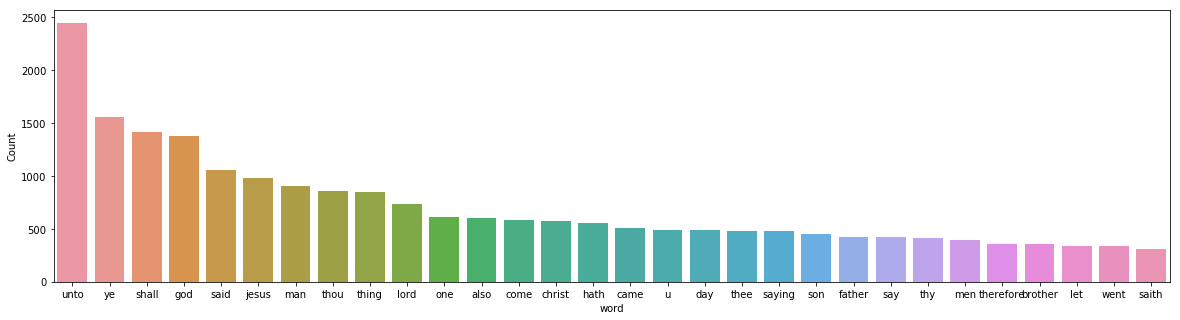

['unto',
 'ye',
 'shall',
 'god',
 'said',
 'jesus',
 'man',
 'thou',
 'thing',
 'lord',
 'one',
 'also',
 'come',
 'christ',
 'hath',
 'came',
 'u',
 'day',
 'thee',
 'saying',
 'son',
 'father',
 'say',
 'thy',
 'men',
 'therefore',
 'brother',
 'let',
 'went',
 'saith']

In [281]:
freq_words(join_tokenized_verses(new_test_lemmatized))

In [25]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        colormap='seismic',
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12),dpi=300)
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

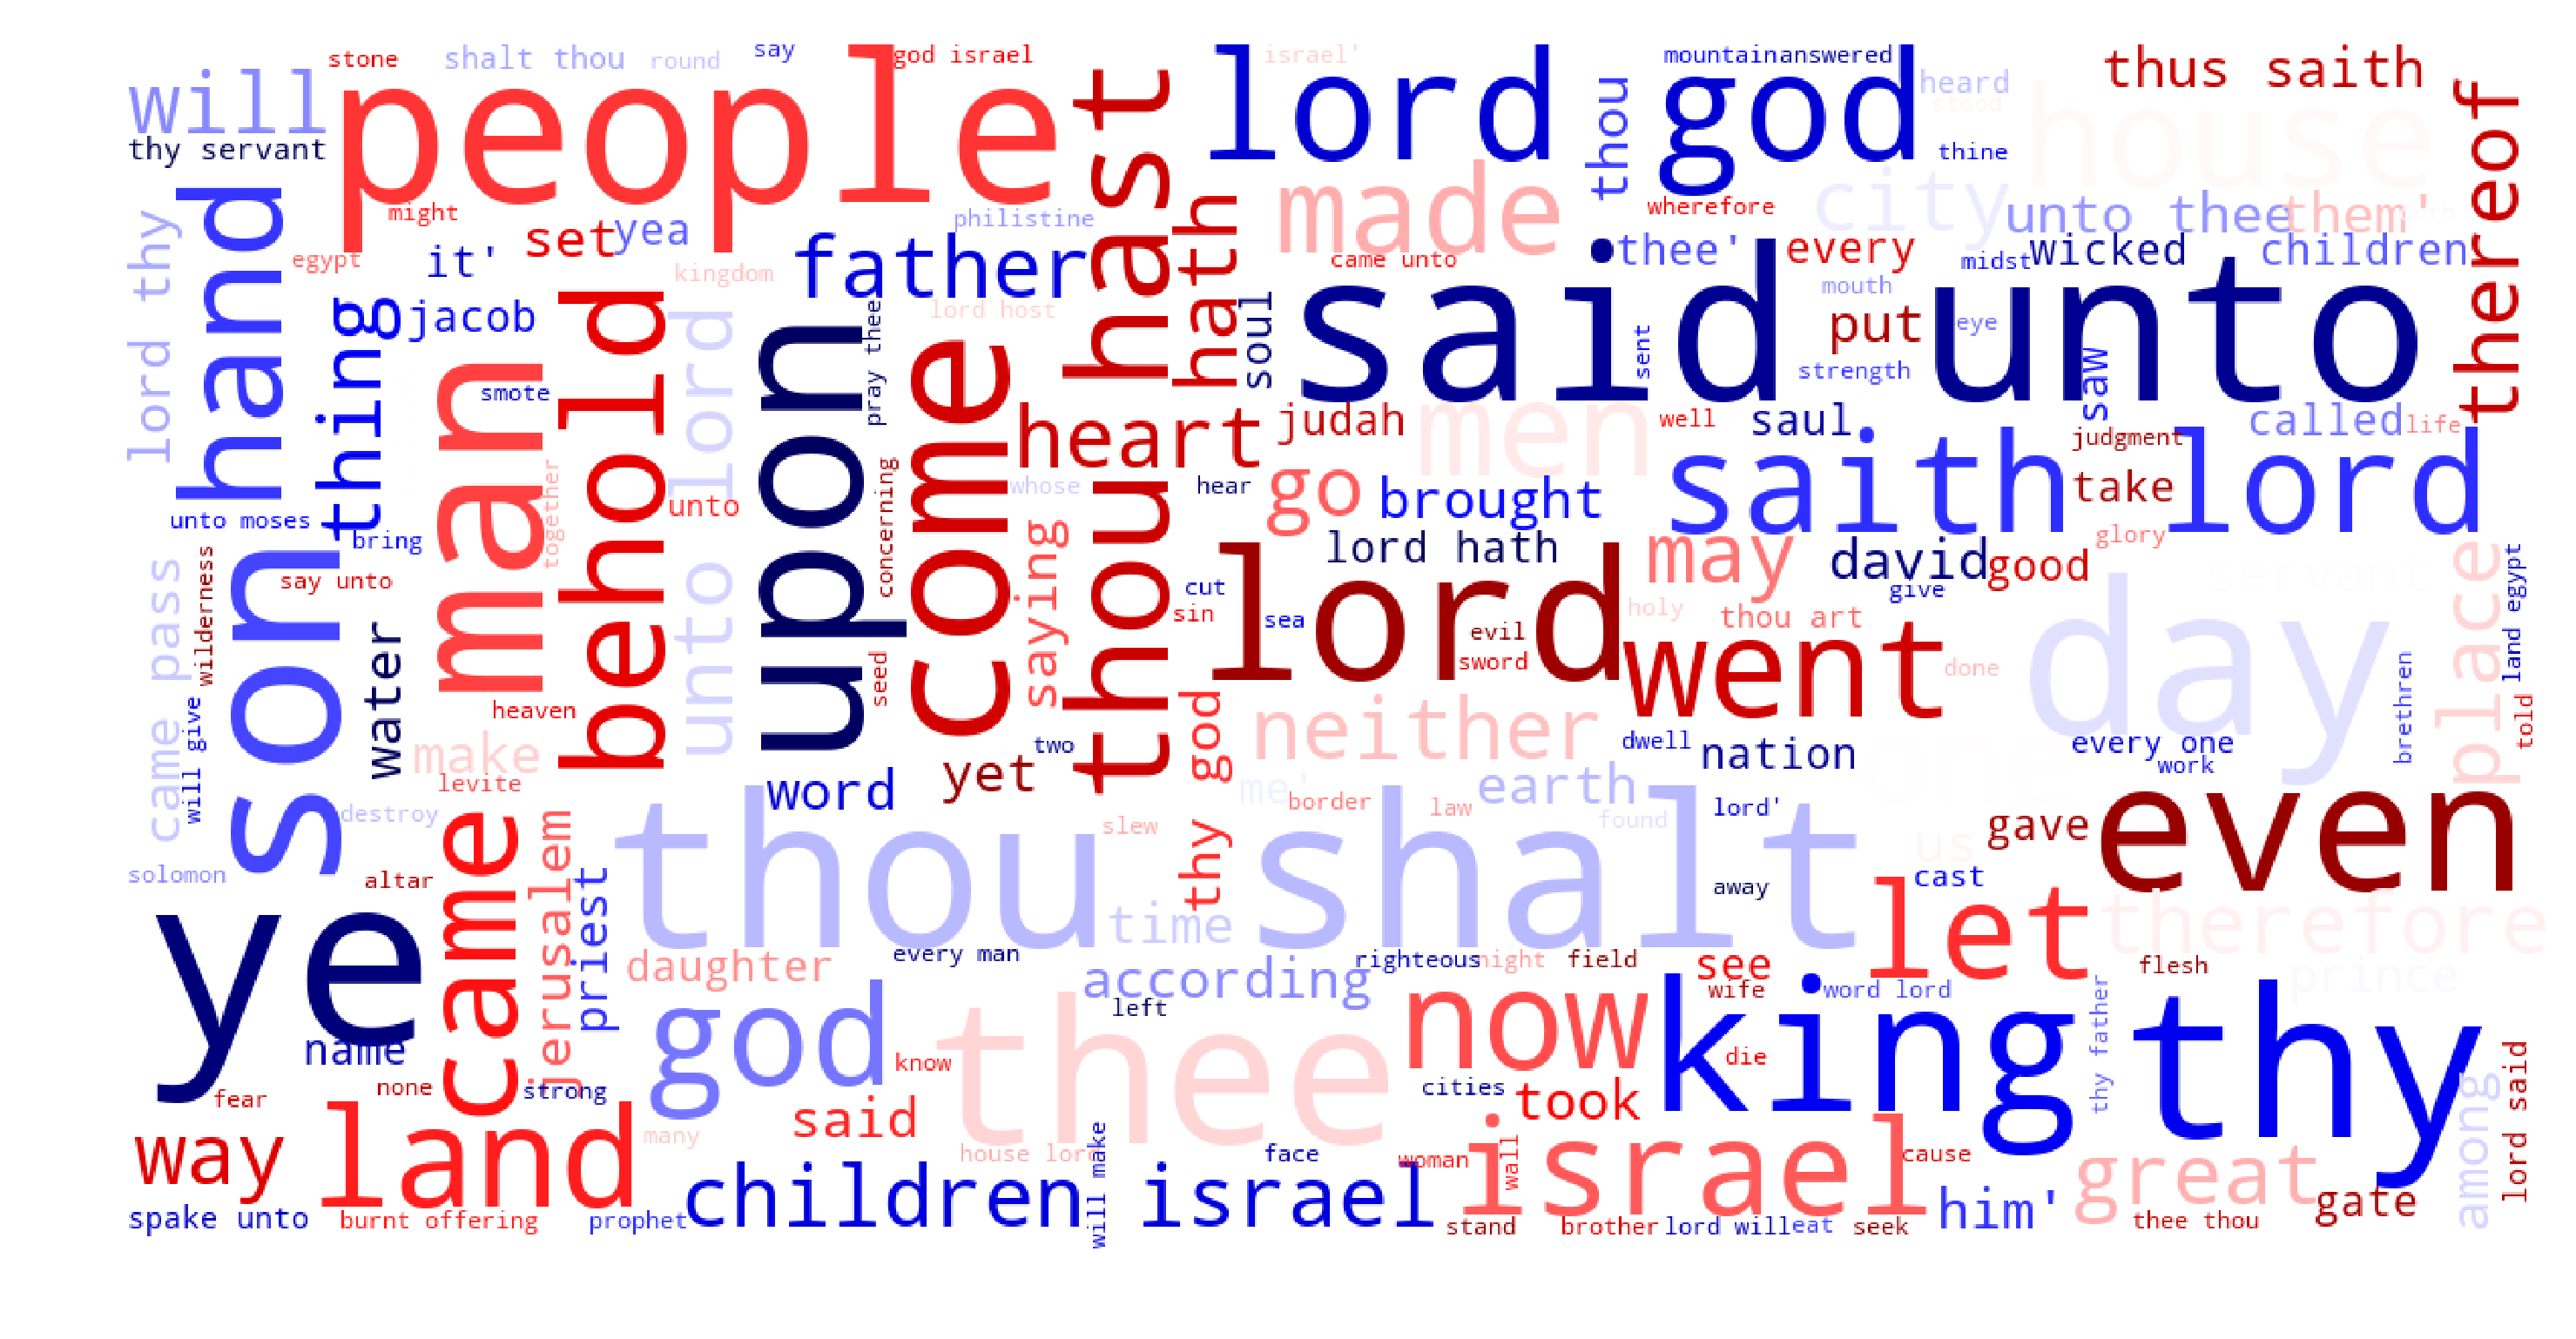

In [122]:
show_wordcloud(clean_old_testament)

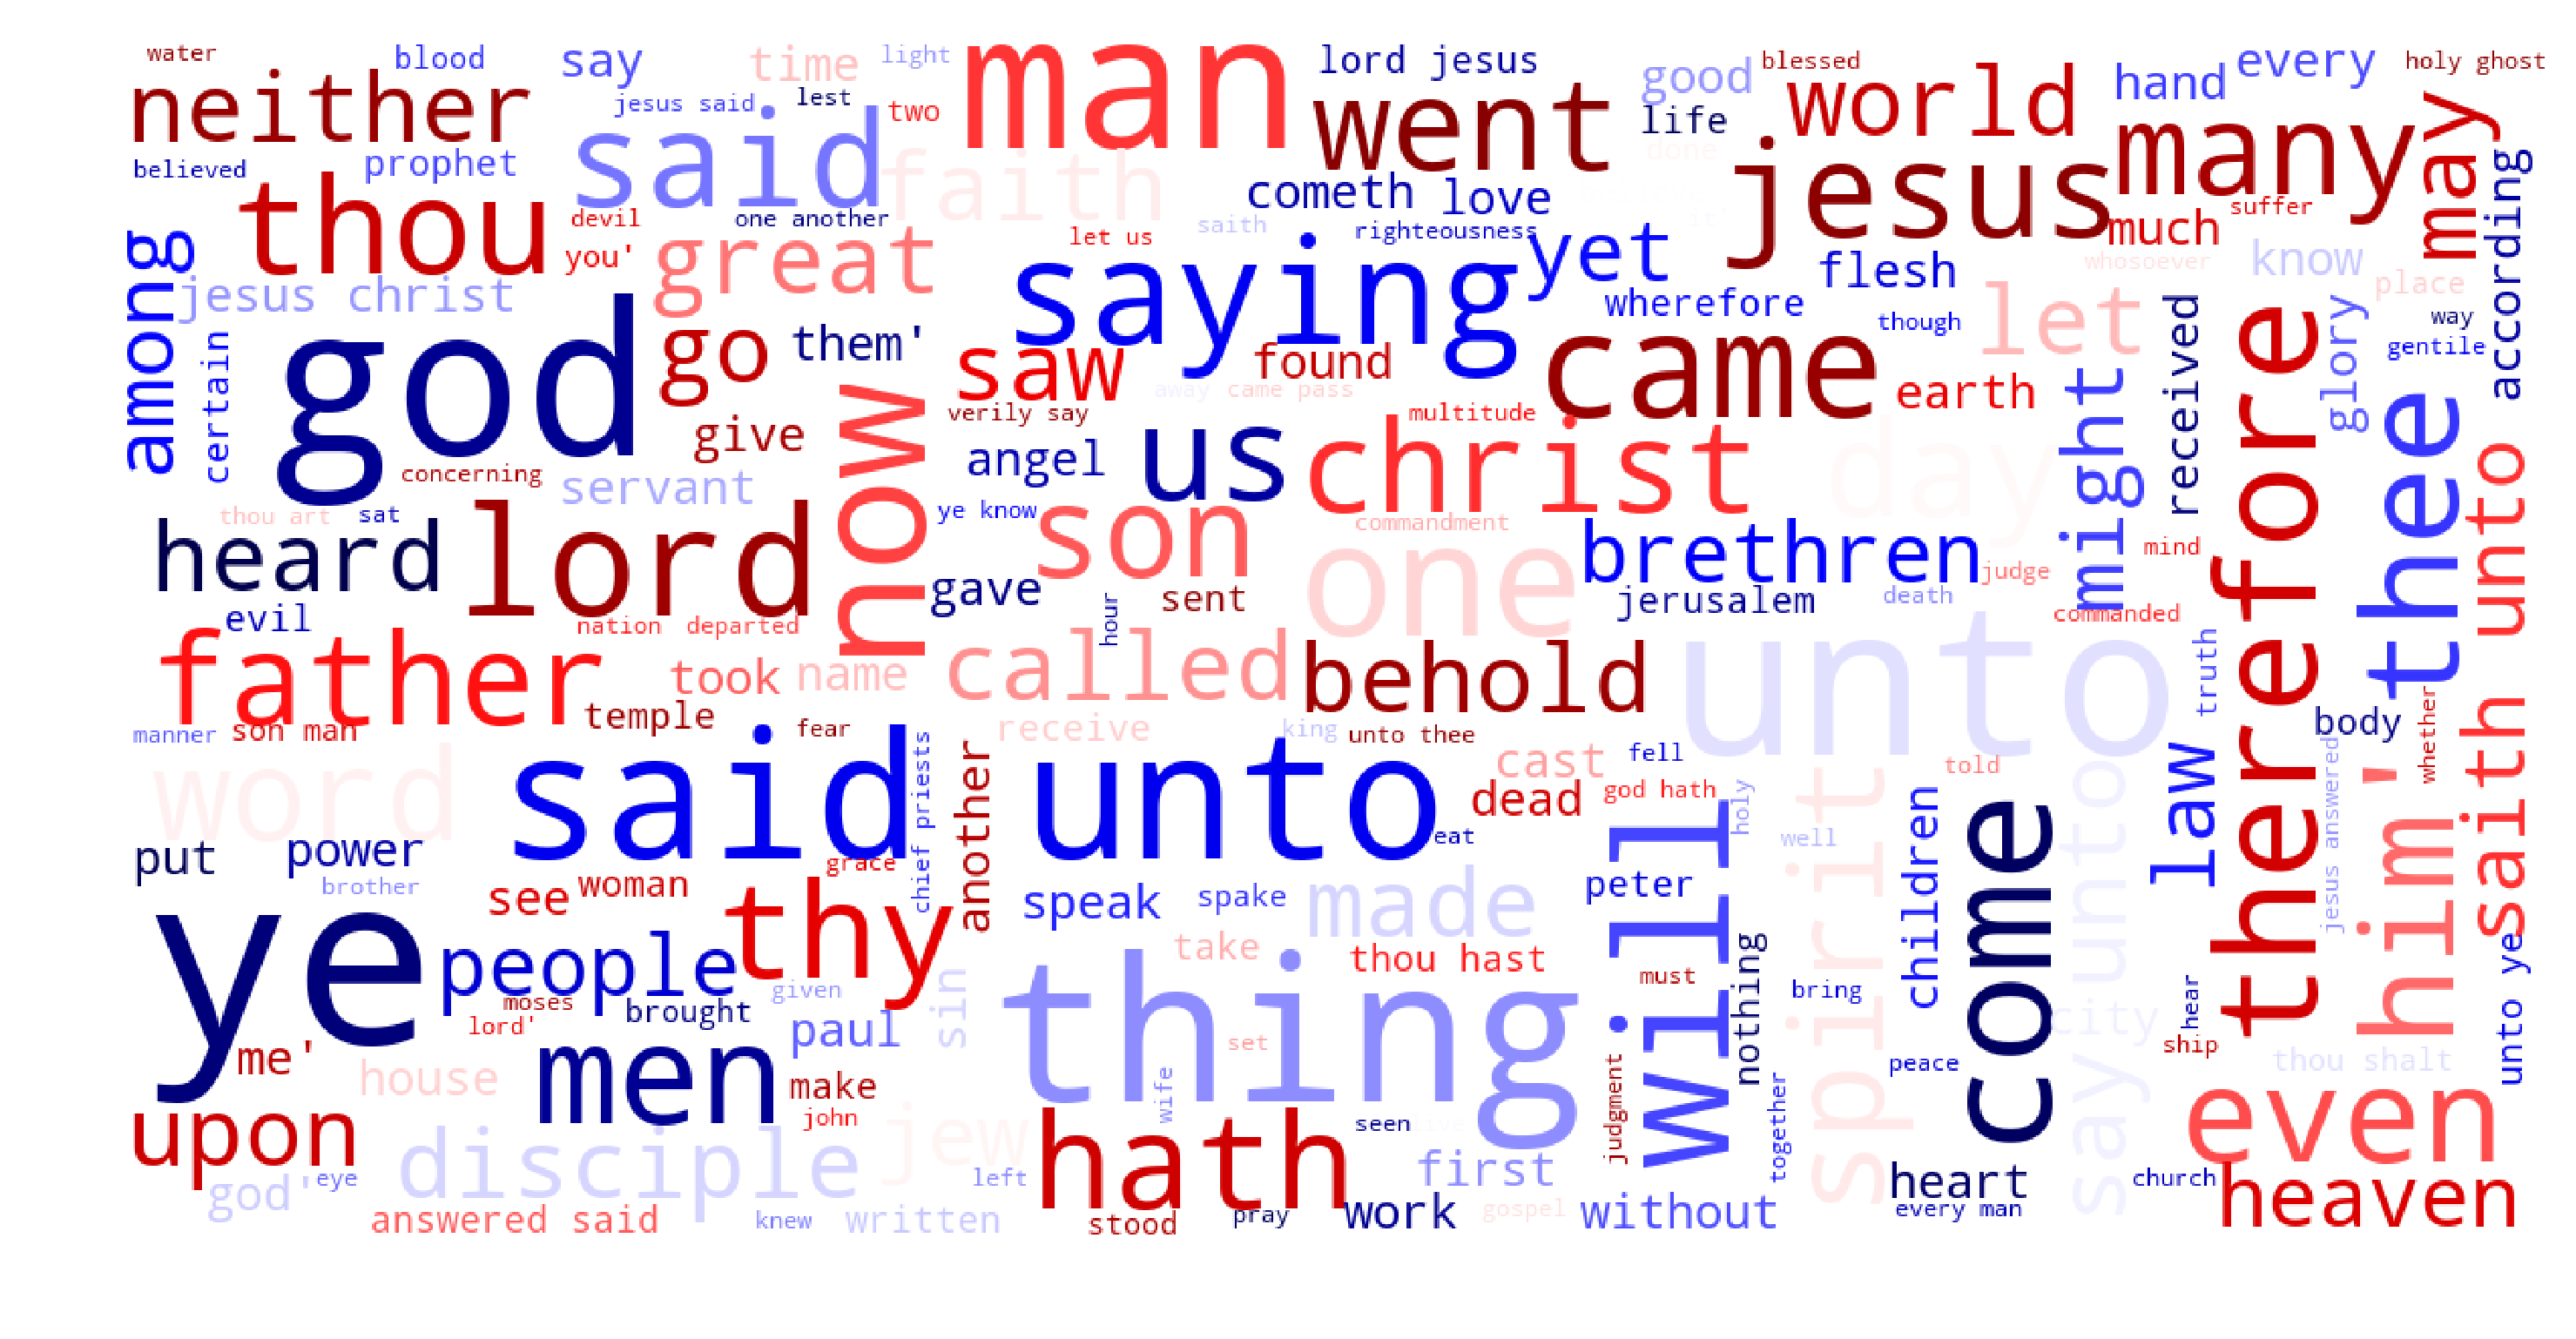

In [27]:
show_wordcloud(clean_new_testament)

## Model Preparation: Count Vectorization/ tf-idf

In [348]:
def display_topics(model, feature_names, no_top_words):
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        topic_list.append(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('Topic %d:' % (topic_idx))
        print(topic_list[topic_idx])
#     return topic_list

In [416]:
# Old Testament

old_test_lem_cv = CountVectorizer()
old_test_lem_cv_sp_matrix = old_test_lem_cv.fit_transform(join_tokenized_words(old_test_lemmatized))

old_test_lem_tfidf = TfidfVectorizer()
old_test_lem_tfidf_sp_matrix = old_test_lem_tfidf.fit_transform(join_tokenized_words(old_test_lemmatized))

In [417]:
# New Testament

new_test_lem_cv = CountVectorizer()
new_test_lem_cv_sp_matrix = new_test_lem_cv.fit_transform(join_tokenized_words(new_test_lemmatized))

new_test_lem_tfidf = TfidfVectorizer()
new_test_lem_tfidf_sp_matrix = new_test_lem_tfidf.fit_transform(join_tokenized_words(new_test_lemmatized))

## Topic Modeling - Old Testament
### LSA - CV

In [418]:
lsa = TruncatedSVD(10)
lsa_doc_topic = lsa.fit_transform(old_test_lem_cv_sp_matrix)
lsa.explained_variance_ratio_

array([0.01327289, 0.01551487, 0.01337596, 0.01054792, 0.00827712,
       0.00725513, 0.00695803, 0.00675822, 0.00640141, 0.00594563])

In [419]:
sum(lsa.explained_variance_ratio_)

0.09430717313633

In [420]:
lsa_topic_words = pd.DataFrame(lsa.components_.round(3),
             index = [x for x in range(1,11)],
             columns = old_test_lem_cv.get_feature_names())

In [421]:
display_topics(lsa, old_test_lem_cv.get_feature_names(), 10)

Topic 0:
child offering saying city son priest even saith behold made
Topic 1:
child tribe ammon giddel inheritance manasseh nekoda family reuben ziha
Topic 2:
offering burnt lamb meat child ram shekel sin bullock offer
Topic 3:
son brother twelve hundred daughter two twentieth year aaron begat
Topic 4:
hast son offering thine saith brother behold saying heart thus
Topic 5:
priest thereof city place altar make take put went every
Topic 6:
city saith thus saying judah word jerusalem offering year say
Topic 7:
david went servant saul city priest philistine offering took saying
Topic 8:
city hast offering thine thereof brother village son twelve earth
Topic 9:
city time priest year hast day thine every may seven


### LSA - tf-idf

In [422]:
lsa = TruncatedSVD(10)
lsa_doc_topic = lsa.fit_transform(old_test_lem_tfidf_sp_matrix)
lsa.explained_variance_ratio_

array([0.00235548, 0.00486308, 0.00449661, 0.00391015, 0.00358802,
       0.0033059 , 0.00319606, 0.00307856, 0.00303198, 0.0027942 ])

In [423]:
sum(lsa.explained_variance_ratio_)

0.03462003445703399

In [424]:
lsa_topic_words = pd.DataFrame(lsa.components_.round(3),
             index = [x for x in range(1,11)],
             columns = old_test_lem_tfidf.get_feature_names())

In [426]:
display_topics(lsa, old_test_lem_tfidf.get_feature_names(), 10)

Topic 0:
child moses saying david offering city word saith behold hast
Topic 1:
offering child burnt hundred moses thousand altar offer priest two
Topic 2:
offering burnt sin altar offer hast thine sacrifice meat make
Topic 3:
child moses aaron commanded spake saying congregation word speak according
Topic 4:
david went saul servant saying moses philistine sent word spake
Topic 5:
saith thus city judah jerusalem word host babylon saying say
Topic 6:
word year saying saith thus thine offering heart old day
Topic 7:
name year praise son jerusalem called daughter judah ever reigned
Topic 8:
child city david hast offering thine tribe inheritance praise burnt
Topic 9:
name word thousand praise earth hundred make saith david called


### NMF - CV

In [427]:
nmf = NMF(10)
nmf_doc_topic = nmf.fit_transform(old_test_lem_cv_sp_matrix)

In [428]:
nmf_topic_words = pd.DataFrame(nmf.components_.round(3),
             index = [x for x in range(1,11)],
             columns = old_test_lem_cv.get_feature_names())

In [429]:
topic_list_cv = display_topics(nmf, old_test_lem_cv.get_feature_names(), 10)

Topic 0:
priest thereof made put place make take altar moses tabernacle
Topic 1:
child moses tribe among inheritance saying spake ammon family father
Topic 2:
offering burnt meat lamb sin ram bullock offer sacrifice shekel
Topic 3:
son brother twelve daughter twentieth aaron wife family joseph moses
Topic 4:
year hundred thousand two five twenty three old begat seven
Topic 5:
city village judah suburb jerusalem tribe king gate even border
Topic 6:
saith thus saying word behold say therefore judah host even
Topic 7:
david went servant saul philistine took brought pas sent border
Topic 8:
hast thine heart thing way earth eye made great mine
Topic 9:
time every thing earth according keep beast pas stone even


### NMF - tf-idf

In [430]:
nmf = NMF(10)
nmf_doc_topic = nmf.fit_transform(old_test_lem_tfidf_sp_matrix)

In [431]:
nmf_topic_words = pd.DataFrame(nmf.components_.round(3),
             index = [x for x in range(1,11)],
             columns = old_test_lem_tfidf.get_feature_names())

In [432]:
topic_list_tfidf = display_topics(nmf, old_test_lem_tfidf.get_feature_names(), 10)

Topic 0:
hast thine heart mine way eye thing enemy done good
Topic 1:
thousand hundred two five twenty numbered three four fifty six
Topic 2:
offering burnt offer altar sin sacrifice meat priest peace bullock
Topic 3:
moses aaron commanded congregation son tabernacle spake saying according pharaoh
Topic 4:
david went saul servant philistine sent jonathan took told saying
Topic 5:
saith word thus saying behold say therefore host speak prophet
Topic 6:
year jerusalem judah old reigned day reign began month twenty
Topic 7:
name praise called ever jacob son daughter sing give wife
Topic 8:
child tribe inheritance city family among ammon manasseh benjamin father
Topic 9:
earth city thereof every made place make water heaven forth


### LDA - CV

In [433]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(old_test_lem_cv_sp_matrix.transpose())

In [434]:
id2word = dict((v, k) for k, v in old_test_lem_cv.vocabulary_.items())

In [435]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5)

In [436]:
lda.print_topics()

[(0,
  '0.025*"child" + 0.024*"judgment" + 0.021*"among" + 0.019*"egypt" + 0.015*"ever" + 0.014*"heathen" + 0.014*"desolate" + 0.013*"name" + 0.012*"great" + 0.012*"nation"'),
 (1,
  '0.034*"earth" + 0.018*"heaven" + 0.015*"water" + 0.012*"eat" + 0.011*"every" + 0.011*"thing" + 0.011*"face" + 0.011*"behold" + 0.010*"beast" + 0.010*"end"'),
 (2,
  '0.043*"thereof" + 0.022*"like" + 0.015*"round" + 0.015*"gold" + 0.014*"cubit" + 0.014*"wall" + 0.012*"stone" + 0.012*"made" + 0.011*"silver" + 0.010*"wisdom"'),
 (3,
  '0.024*"thousand" + 0.021*"righteousness" + 0.019*"tree" + 0.018*"praise" + 0.017*"hundred" + 0.014*"seven" + 0.014*"month" + 0.013*"day" + 0.013*"transgression" + 0.012*"battle"'),
 (4,
  '0.023*"king" + 0.016*"piece" + 0.014*"slain" + 0.013*"moab" + 0.012*"woe" + 0.011*"chamber" + 0.011*"cut" + 0.010*"made" + 0.008*"captain" + 0.008*"palace"'),
 (5,
  '0.026*"saith" + 0.015*"babylon" + 0.014*"yet" + 0.013*"bring" + 0.012*"fall" + 0.012*"thus" + 0.012*"seek" + 0.011*"among" + 

### LDA - tf-idf

In [437]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(old_test_lem_tfidf_sp_matrix.transpose())

In [438]:
id2word = dict((v, k) for k, v in old_test_lem_tfidf.vocabulary_.items())

In [439]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5)

In [440]:
lda.print_topics()

[(0,
  '0.015*"thousand" + 0.015*"hundred" + 0.012*"cubit" + 0.011*"four" + 0.011*"battle" + 0.010*"twenty" + 0.009*"five" + 0.008*"year" + 0.008*"chamber" + 0.008*"three"'),
 (1,
  '0.017*"saith" + 0.010*"thus" + 0.010*"word" + 0.008*"saying" + 0.008*"host" + 0.007*"prophet" + 0.007*"hear" + 0.006*"therefore" + 0.006*"nation" + 0.006*"even"'),
 (2,
  '0.010*"judah" + 0.009*"david" + 0.009*"salvation" + 0.007*"king" + 0.007*"vanity" + 0.007*"jerusalem" + 0.006*"high" + 0.006*"throne" + 0.006*"anger" + 0.006*"book"'),
 (3,
  '0.010*"gate" + 0.010*"side" + 0.010*"shame" + 0.010*"ashamed" + 0.009*"captivity" + 0.008*"understanding" + 0.008*"temple" + 0.007*"thereof" + 0.007*"new" + 0.007*"court"'),
 (4,
  '0.014*"praise" + 0.010*"lion" + 0.009*"devour" + 0.008*"prophesy" + 0.007*"jonah" + 0.007*"wine" + 0.006*"glad" + 0.006*"fruit" + 0.006*"break" + 0.006*"enter"'),
 (5,
  '0.014*"saith" + 0.011*"zion" + 0.008*"ephraim" + 0.008*"sword" + 0.007*"desolate" + 0.007*"heathen" + 0.006*"broken"

## Topic Modeling - New Testament
### LSA - CV

In [441]:
lsa = TruncatedSVD(10)
lsa_doc_topic = lsa.fit_transform(new_test_lem_cv_sp_matrix)
lsa.explained_variance_ratio_

array([0.07750211, 0.01291676, 0.01896205, 0.00998363, 0.00776799,
       0.00736885, 0.0063534 , 0.0058477 , 0.0055634 , 0.00516397])

In [442]:
sum(lsa.explained_variance_ratio_)

0.15742986281798232

In [443]:
lsa_topic_words = pd.DataFrame(lsa.components_.round(3),
             index = [x for x in range(1,11)],
             columns = new_test_lem_cv.get_feature_names())

In [444]:
display_topics(lsa, new_test_lem_cv.get_feature_names(), 10)

Topic 0:
son joseph juda levi cainan mattathias matthat melchi david abraham
Topic 1:
thing begat say made heaven may every many word know
Topic 2:
begat jacob isaac jesse salmon naasson booz esrom phares obed
Topic 3:
thing whatsoever begat seen many write chosen confound charity son
Topic 4:
law faith might world spirit according every good may made
Topic 5:
say law verily sin know may answered go faith good
Topic 6:
law jew people disciple priest might many chief without called
Topic 7:
heaven law say earth sin upon angel great power verily
Topic 8:
spirit another word flesh say many disciple heard verily thing
Topic 9:
made world glory sin priest body say power might according


### LSA - tf-idf

In [445]:
lsa = TruncatedSVD(10)
lsa_doc_topic = lsa.fit_transform(new_test_lem_tfidf_sp_matrix)
lsa.explained_variance_ratio_

array([0.00229686, 0.00478234, 0.00453883, 0.00416408, 0.00388501,
       0.00372432, 0.00365818, 0.0034767 , 0.00340538, 0.00330469])

In [446]:
sum(lsa.explained_variance_ratio_)

0.03723638000219705

In [447]:
lsa_topic_words = pd.DataFrame(lsa.components_.round(3),
             index = [x for x in range(1,11)],
             columns = new_test_lem_tfidf.get_feature_names())

In [448]:
display_topics(lsa, new_test_lem_tfidf.get_feature_names(), 10)

Topic 0:
thing say son know word disciple many heaven heard spirit
Topic 1:
thing know world may speak love seen done good faith
Topic 2:
thing disciple heard done priest many chief people jerusalem john
Topic 3:
say verily son know answered kingdom see life whosoever art
Topic 4:
son heaven thing angel art life david earth glory saw
Topic 5:
know son disciple answered life sent may peter go love
Topic 6:
heaven know earth love angel kingdom spirit great word voice
Topic 7:
spirit hear word ear many flesh son disciple speak law
Topic 8:
know law sin hand jew took heaven spirit put made
Topic 9:
world go sent light away sin even made neither believe


### NMF - CV

In [449]:
nmf = NMF(10)
nmf_doc_topic = nmf.fit_transform(new_test_lem_cv_sp_matrix)

In [450]:
nmf_topic_words = pd.DataFrame(nmf.components_.round(3),
             index = [x for x in range(1,11)],
             columns = new_test_lem_cv.get_feature_names())

In [451]:
topic_list_cv = display_topics(nmf, new_test_lem_cv.get_feature_names(), 10)

Topic 0:
son joseph juda levi matthat cainan mattathias melchi david abraham
Topic 1:
disciple people go house priest many hand called day behold
Topic 2:
begat jacob brother isaac king david juda babylon solomon jesse
Topic 3:
thing many whatsoever seen done heard hast tell write know
Topic 4:
made may world faith every even glory according might know
Topic 5:
say verily sin whosoever see answered eye kingdom know thine
Topic 6:
law jew sin might without written righteousness judge justified flesh
Topic 7:
heaven earth great upon angel voice saw sea beast heard
Topic 8:
spirit another word flesh truth tongue love given know unclean
Topic 9:
good evil forth fruit work heart give tree bringeth life


### NMF - tf-idf

In [452]:
nmf = NMF(10)
nmf_doc_topic = nmf.fit_transform(new_test_lem_tfidf_sp_matrix)

In [453]:
nmf_topic_words = pd.DataFrame(nmf.components_.round(3),
             index = [x for x in range(1,11)],
             columns = new_test_lem_tfidf.get_feature_names())

In [454]:
topic_list_tfidf = display_topics(nmf, new_test_lem_tfidf.get_feature_names(), 10)

Topic 0:
many people priest jew chief word paul heard jerusalem answered
Topic 1:
thing done seen may spoken told heard speak many tell
Topic 2:
law sin faith love good grace work made every another
Topic 3:
say verily kingdom see answered prophet till eat drink generation
Topic 4:
heaven earth upon great hand angel saw kingdom voice power
Topic 5:
son life art david mercy hour cried answered believeth believe
Topic 6:
know truth love sent answered known commandment hereby even true
Topic 7:
spirit hear ear flesh church unclean word given see speak
Topic 8:
world word sent light even may believe hast life given
Topic 9:
disciple go peter house away eat sent way ship two


### LDA - CV

In [455]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(new_test_lem_cv_sp_matrix.transpose())

In [456]:
id2word = dict((v, k) for k, v in new_test_lem_cv.vocabulary_.items())

In [457]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5)

In [458]:
lda.print_topics()

[(0,
  '0.019*"see" + 0.015*"thing" + 0.015*"priest" + 0.014*"glory" + 0.013*"say" + 0.010*"believe" + 0.008*"people" + 0.008*"tell" + 0.008*"son" + 0.008*"power"'),
 (1,
  '0.016*"heaven" + 0.015*"great" + 0.015*"seven" + 0.014*"voice" + 0.014*"earth" + 0.012*"first" + 0.012*"sea" + 0.012*"angel" + 0.010*"upon" + 0.010*"thousand"'),
 (2,
  '0.025*"grace" + 0.015*"hand" + 0.014*"cast" + 0.013*"upon" + 0.013*"put" + 0.012*"light" + 0.011*"great" + 0.011*"foot" + 0.010*"wife" + 0.010*"fire"'),
 (3,
  '0.023*"law" + 0.019*"faith" + 0.016*"sin" + 0.014*"life" + 0.014*"made" + 0.013*"according" + 0.012*"church" + 0.012*"child" + 0.012*"might" + 0.012*"without"'),
 (4,
  '0.038*"son" + 0.011*"manifest" + 0.010*"lamb" + 0.010*"honour" + 0.009*"peace" + 0.009*"worthy" + 0.008*"house" + 0.008*"departed" + 0.008*"love" + 0.007*"affliction"'),
 (5,
  '0.015*"away" + 0.011*"peter" + 0.011*"though" + 0.011*"sent" + 0.011*"word" + 0.011*"body" + 0.010*"go" + 0.009*"yet" + 0.008*"would" + 0.008*"disc

### LDA - tf-idf

In [459]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(new_test_lem_tfidf_sp_matrix.transpose())

In [460]:
id2word = dict((v, k) for k, v in new_test_lem_tfidf.vocabulary_.items())

In [461]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5)

In [462]:
lda.print_topics()

[(0,
  '0.007*"two" + 0.007*"go" + 0.006*"manifest" + 0.006*"disciple" + 0.006*"ship" + 0.005*"followed" + 0.005*"labour" + 0.005*"house" + 0.005*"death" + 0.005*"departed"'),
 (1,
  '0.011*"saint" + 0.009*"spirit" + 0.009*"thing" + 0.009*"hope" + 0.009*"faith" + 0.009*"abraham" + 0.009*"keep" + 0.008*"according" + 0.007*"promise" + 0.007*"love"'),
 (2,
  '0.007*"beast" + 0.007*"husband" + 0.006*"love" + 0.006*"wife" + 0.006*"another" + 0.005*"witness" + 0.005*"dead" + 0.005*"free" + 0.005*"light" + 0.005*"loveth"'),
 (3,
  '0.008*"truth" + 0.008*"life" + 0.008*"thing" + 0.008*"say" + 0.007*"may" + 0.007*"flesh" + 0.007*"live" + 0.006*"verily" + 0.006*"sin" + 0.005*"know"'),
 (4,
  '0.006*"present" + 0.006*"justified" + 0.006*"weak" + 0.006*"thing" + 0.006*"confidence" + 0.006*"law" + 0.005*"preached" + 0.005*"seen" + 0.005*"synagogue" + 0.005*"people"'),
 (5,
  '0.007*"lamb" + 0.005*"bond" + 0.005*"patience" + 0.005*"tree" + 0.005*"fruit" + 0.004*"sepulchre" + 0.004*"repent" + 0.004*"

### WordtoVec

In [389]:
# Load Google's pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/tcbon/Downloads/GoogleNews-vectors-negative300.bin', binary=True)  

NameError: name 'gensim' is not defined

In [ ]:
# Convert topics to word2vec representation
topic_vectors = []
for topic in topic_list_tfidf:
    row_vector = []
    for w in topic.split():
        try:
            row_vector.append(model.get_vector(w))
        except:
            print(w)
    topic_vectors.append(row_vector)

In [ ]:
# Get mean word2vec representation for topics
topic_2_vec = []
for vec_list in topic_vectors:
    vec_sum = np.array(np.zeros((300,)))
    for topic_vec in vec_list:
        vec_sum = vec_sum + topic_vec
    topic_2_vec.append(vec_sum)
    
# goog_model.most_similar_cosmul(positive=preprocess_string(topic_list[0]))[0:3]

In [ ]:
topics = []
for i, val in enumerate(topic_2_vec):
    topics.append(model.similar_by_vector(val, topn=5, restrict_vocab=1500))
    print('Topic' + str(i))
    print(topics[i])

### PCA/ T-SNE

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform()

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))